In [33]:
import os
import sys
import pyproj
import geopandas as gpd
from shapely.geometry import mapping
import rasterio
from rasterio.mask import mask
import numpy as np
from shapely.geometry import box
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import cKDTree

In [34]:
from utils import load_geotif, save_features_to_shapefile
from car_recogn_comparison import extract_image_chip, compare_image_chips

In [35]:
conda_prefix = sys.prefix
proj_lib = os.path.join(conda_prefix, "Library", "share", "proj")
pyproj.datadir.set_data_dir(proj_lib)
print(f"Manually set PROJ_LIB to: {pyproj.datadir.get_data_dir()}")
dataset, geotransform, projection = load_geotif('image_data/auckland-0075m-urban-aerial-photos-2017.tif')

Manually set PROJ_LIB to: c:\Users\david.bruner\.conda\envs\geoaienv\Library\share\proj


c:\Users\david.bruner\.conda\envs\geoaienv\Lib\site-packages\osgeo\gdal.py:4216: RuntimeWarning: PROJ: proj_create_from_database: C:\Program Files\PostgreSQL\13\share\contrib\postgis-3.4\proj\proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.
  return _gdal.Dataset_GetProjection(self, *args)
c:\Users\david.bruner\.conda\envs\geoaienv\Lib\site-packages\osgeo\gdal.py:4216: RuntimeWarning: PROJ: proj_create_from_database: C:\Program Files\PostgreSQL\13\share\contrib\postgis-3.4\proj\proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 4 is expected. It comes from another PROJ installation.
  return _gdal.Dataset_GetProjection(self, *args)
c:\Users\david.bruner\.conda\envs\geoaienv\Lib\site-packages\osgeo\gdal.py:4216: RuntimeWarning: The definition of projected CRS EPSG:2193 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operati

In [36]:
RASTER_PATH_2016 = "image_data/auckland-0075m-urban-aerial-photos-2015-2016.tif"
RASTER_PATH_2017 = "image_data/auckland-0075m-urban-aerial-photos-2017.tif"
BBOXES_PATH_2016 = "demo/car_detections_2016.gpkg"
BBOXES_PATH_2017 = "demo/car_detections_2017.gpkg"

In [37]:
bbox_2016_gdf = gpd.read_file(BBOXES_PATH_2016)
bbox_2017_gdf = gpd.read_file(BBOXES_PATH_2017)

In [38]:
def find_close_boxes(gdf1: gpd.GeoDataFrame, gdf2: gpd.GeoDataFrame, distance_threshold: float = 1.0) -> gpd.GeoDataFrame:
    """
    Find close pairs of bounding boxes between two GeoDataFrames using their centroids.

    :param gdf1: GeoDataFrame containing bounding boxes from the first image
    :param gdf2: GeoDataFrame containing bounding boxes from the second image
    :param distance_threshold: Maximum distance to consider centroids as matching
    :return: GeoDataFrame containing matched pairs of bounding boxes
    """
    # Calculate centroids
    gdf1['centroid'] = gdf1.geometry.centroid
    gdf2['centroid'] = gdf2.geometry.centroid

    # Convert centroids to numpy arrays for KDTree
    centroids1_array = np.array([(c.x, c.y) for c in gdf1['centroid']])
    centroids2_array = np.array([(c.x, c.y) for c in gdf2['centroid']])

    # Build KDTree for faster nearest neighbor search
    tree = cKDTree(centroids2_array)

    # Find nearest neighbors
    distances, indices = tree.query(centroids1_array, k=1, distance_upper_bound=distance_threshold)

    # Create a list of matched pairs
    matched_pairs = [(i, j) for i, (d, j) in enumerate(zip(distances, indices)) if d <= distance_threshold]

    # Create a new GeoDataFrame with matched pairs
    if matched_pairs:
        matched_df = gpd.GeoDataFrame({
            'index_1': [pair[0] for pair in matched_pairs],
            'index_2': [pair[1] for pair in matched_pairs],
            'geometry_1': gdf1.loc[[pair[0] for pair in matched_pairs], 'geometry'].values,
            'geometry_2': gdf2.loc[[pair[1] for pair in matched_pairs], 'geometry'].values,
            'centroid_1': gdf1.loc[[pair[0] for pair in matched_pairs], 'centroid'].values,
            'centroid_2': gdf2.loc[[pair[1] for pair in matched_pairs], 'centroid'].values,
            'distance': [distances[pair[0]] for pair in matched_pairs]
        })

        # Set the geometry to the centroid of the first image for spatial operations
        matched_df.set_geometry('centroid_1', inplace=True)

        # Set the CRS to match the input GeoDataFrames
        matched_df.set_crs(gdf1.crs, inplace=True)
    else:
        # If no matches found, return an empty GeoDataFrame with the correct structure
        matched_df = gpd.GeoDataFrame(columns=['index_1', 'index_2', 'geometry_1', 'geometry_2', 'centroid_1', 'centroid_2', 'distance'], geometry='centroid_1', crs=gdf1.crs)

    return matched_df

In [39]:
close_pairs = find_close_boxes(bbox_2016_gdf, bbox_2017_gdf)

In [40]:
save_features_to_shapefile(close_pairs["geometry_1"].tolist(), projection, 'demo/close_pairs_2016')
save_features_to_shapefile(close_pairs["geometry_2"].tolist(), projection, 'demo/close_pairs_2017')

GeoDataFrame saved to demo/close_pairs_2016
GeoDataFrame saved to demo/close_pairs_2017


In [41]:
def compare_detections_main(raster_path1, raster_path2, boxes_path1, boxes_path2, high_similarity_threshold=0.9):
    boxes1 = gpd.read_file(boxes_path1)
    boxes2 = gpd.read_file(boxes_path2)

    close_pairs = find_close_boxes(boxes1, boxes2)

    results = []

    for i, row in close_pairs.iterrows():
        geometry1 = row['geometry_1']
        geometry2 = row['geometry_2']

        chip1 = extract_image_chip(raster_path1, geometry1)
        chip2 = extract_image_chip(raster_path2, geometry2)

        similarity = compare_image_chips(chip1, chip2)

        results.append((similarity, chip1, chip2, geometry1, geometry2))

    high_similarity_results = []
    high_similarity_geometries1 = []
    high_similarity_geometries2 = []
    for similarity, chip1, chip2, geom1, geom2 in results:
        if similarity > high_similarity_threshold:
            high_similarity_results.append((similarity, chip1, chip2))
            high_similarity_geometries1.append(geom1)
            high_similarity_geometries2.append(geom2)

    return results, high_similarity_results, high_similarity_geometries1, high_similarity_geometries2

In [42]:
results, high_similarity_results, high_similarity_geometries1, high_similarity_geometries2 = compare_detections_main(RASTER_PATH_2016, RASTER_PATH_2017, BBOXES_PATH_2016, BBOXES_PATH_2017)

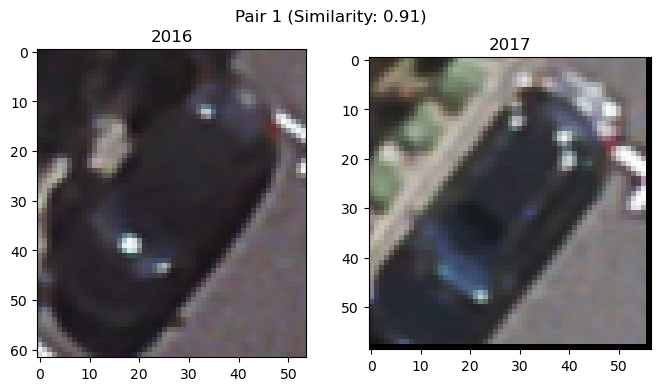

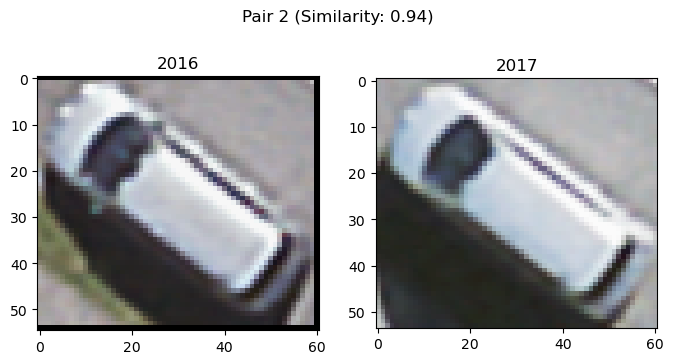

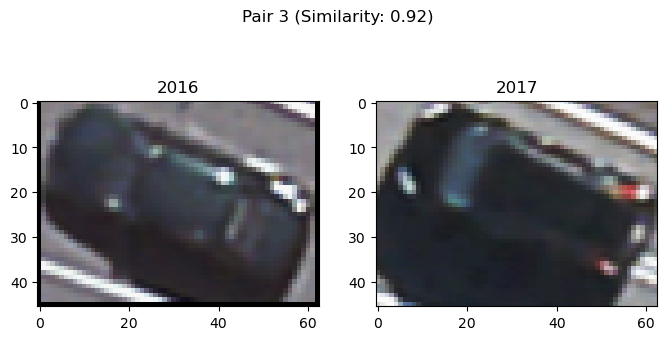

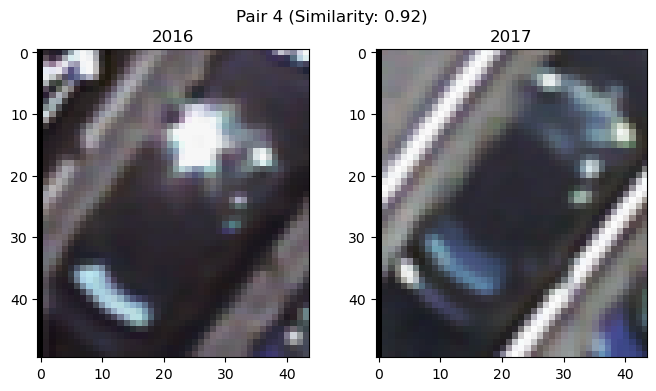

In [43]:
import matplotlib.pyplot as plt

for idx, (similarity, chip1, chip2) in enumerate(high_similarity_results[:10]):
    plt.figure(figsize=(8, 4))
    plt.suptitle(f'Pair {idx + 1} (Similarity: {similarity:.2f})')

    plt.subplot(1,2,1)
    plt.imshow(chip1[:3].transpose(1, 2, 0))
    plt.title('2016')

    plt.subplot(1,2,2)
    plt.imshow(chip2[:3].transpose(1, 2, 0))
    plt.title('2017')

    plt.show()

In [44]:
save_features_to_shapefile(high_similarity_geometries1, projection, 'demo/high_similarity_geometries_2016')
save_features_to_shapefile(high_similarity_geometries2, projection, 'demo/high_similarity_geometries_2017')

GeoDataFrame saved to demo/high_similarity_geometries_2016
GeoDataFrame saved to demo/high_similarity_geometries_2017
